In [54]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
df = pd.read_csv('../Data/Language Detection.csv')

In [3]:
df.head()

,Text,Language
0,"Nature, in the broadest sense, is the natural...",English
1,"""Nature"" can refer to the phenomena of the phy...",English
2,"The study of nature is a large, if not the onl...",English
3,"Although humans are part of nature, human acti...",English
4,[1] The word nature is borrowed from the Old F...,English


In [4]:
df.tail()

,Text,Language
10332,ನಿಮ್ಮ ತಪ್ಪು ಏನು ಬಂದಿದೆಯೆಂದರೆ ಆ ದಿನದಿಂದ ನಿಮಗೆ ಒ...,Kannada
10333,ನಾರ್ಸಿಸಾ ತಾನು ಮೊದಲಿಗೆ ಹೆಣಗಾಡುತ್ತಿದ್ದ ಮಾರ್ಗಗಳನ್...,Kannada
10334,ಹೇಗೆ ' ನಾರ್ಸಿಸಿಸಮ್ ಈಗ ಮರಿಯನ್ ಅವರಿಗೆ ಸಂಭವಿಸಿದ ಎ...,Kannada
10335,ಅವಳು ಈಗ ಹೆಚ್ಚು ಚಿನ್ನದ ಬ್ರೆಡ್ ಬಯಸುವುದಿಲ್ಲ ಎಂದು ...,Kannada
10336,ಟೆರ್ರಿ ನೀವು ನಿಜವಾಗಿಯೂ ಆ ದೇವದೂತನಂತೆ ಸ್ವಲ್ಪ ಕಾಣು...,Kannada


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10337 entries, 0 to 10336
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Text      10337 non-null  object
 1   Language  10337 non-null  object
dtypes: object(2)
memory usage: 161.6+ KB


In [6]:
df.shape

(10337, 2)

In [7]:
df.columns

Index(['Text', 'Language'], dtype='object')

The dataset contains 10,337 rows with two columns: "text" and "language." Both columns have a data type of "object." The "text" column likely contains textual data, while the "language" column may store information about the language of the corresponding text. 

In [8]:
df.duplicated().sum()

66

In [9]:
df.drop_duplicates(inplace=True)

In [10]:
df.duplicated().sum()

0

 It was discovered that there were 66 rows with duplicate data. To address this issue, the decision was made to remove these duplicate rows, resulting in a refined dataset with 10,271 rows. 

In [11]:
df.sample(6)

,Text,Language
8620,välmodig ordet suave har flera olika ursprung ...,Sweedish
10255,ನಾನು ನಿಮಗೆ ಒಂದು ಲೋಟ ನೀರು ತರಬಹುದೇ?,Kannada
8306,[6] Före utgången av 2001 fanns Wikipedia på 1...,Sweedish
1526,"വൃത്തിയാക്കൽ, തങ്ങളുടെ സൃഷ്ടികളേയും മറ്റും സംര...",Malayalam
2561,Novos projetos inspirados na Wikipédia — como ...,Portugeese
5386,puedes hacerlo si alguien lo está haciendo rea...,Spanish


In [12]:
df.isnull().sum()

Text        0
Language    0
dtype: int64

 it does not contain any null or missing values. This indicates that the dataset is complete and does not have any missing data.

In [66]:
df['Language'].value_counts(normalize= True) * 100

3     13.455360
4      9.804303
13     7.944699
11     7.165807
8      6.756888
12     6.698471
14     6.552429
10     5.754065
2      5.276993
0      5.179632
16     4.585727
5      4.527310
15     4.517574
1      4.128128
9      3.563431
6      3.485542
7      0.603641
Name: Language, dtype: float64

In [67]:
OUT_SIZE = len(df['Language'].unique())
OUT_SIZE

17

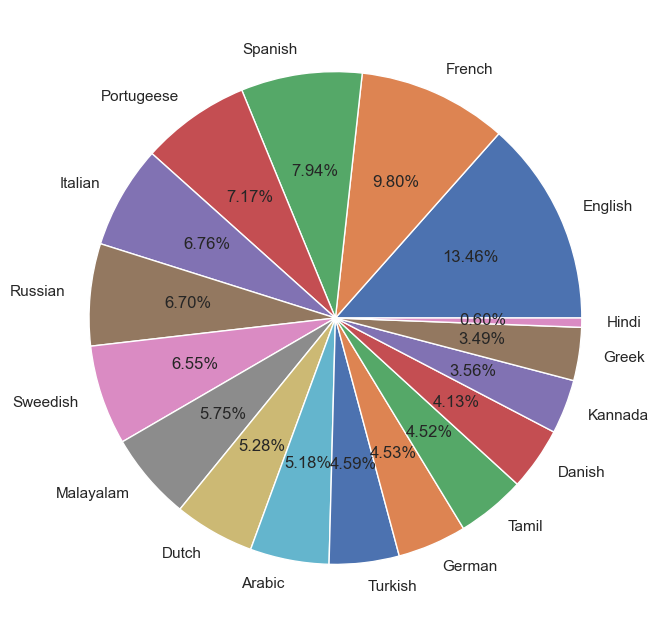

In [14]:
sns.set()
plt.figure(figsize= (8, 8))
plt.pie(x = df['Language'].value_counts(), labels= df['Language'].value_counts().index, autopct= '%1.2f%%')
plt.show()

In [15]:
le = LabelEncoder()
le.fit(df['Language'])

LabelEncoder()

In [16]:
df['Language'] = le.transform(df['Language'])
df['Language']

0        3
1        3
2        3
3        3
4        3
        ..
10332    9
10333    9
10334    9
10335    9
10336    9
Name: Language, Length: 10271, dtype: int32

In [17]:
df['Language'].value_counts(normalize=True) * 100

3     13.455360
4      9.804303
13     7.944699
11     7.165807
8      6.756888
12     6.698471
14     6.552429
10     5.754065
2      5.276993
0      5.179632
16     4.585727
5      4.527310
15     4.517574
1      4.128128
9      3.563431
6      3.485542
7      0.603641
Name: Language, dtype: float64

In [18]:
X = df['Text'].values.flatten()
y = to_categorical(df['Language'])

In [19]:
X[5]

'[2] In ancient philosophy, natura is mostly used as the Latin translation of the Greek word physis (φύσις), which originally related to the intrinsic characteristics that plants, animals, and other features of the world develop of their own accord.'

In [20]:
y[1]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [25]:
ps = PorterStemmer()
corpus = []

for i in range(len(tuple(X))):
    text = re.sub(r'[!@#$(),n"%^*?:;~`0-9]',' ',X[i])
    text = re.sub(r'[[]]', ' ', text)
    text = text.lower()
    text = text.split()
    text = [ps.stem(word) for word in text if not word in stopwords.words('english')]
    text = ' '.join(text)
    
    corpus.append(text)
    
    print(f"status : {i +1} / {len(X)}")

status : 1 / 10271
status : 2 / 10271
status : 3 / 10271
status : 4 / 10271
status : 5 / 10271
status : 6 / 10271
status : 7 / 10271
status : 8 / 10271
status : 9 / 10271
status : 10 / 10271
status : 11 / 10271
status : 12 / 10271
status : 13 / 10271
status : 14 / 10271
status : 15 / 10271
status : 16 / 10271
status : 17 / 10271
status : 18 / 10271
status : 19 / 10271
status : 20 / 10271
status : 21 / 10271
status : 22 / 10271
status : 23 / 10271
status : 24 / 10271
status : 25 / 10271
status : 26 / 10271
status : 27 / 10271
status : 28 / 10271
status : 29 / 10271
status : 30 / 10271
status : 31 / 10271
status : 32 / 10271
status : 33 / 10271
status : 34 / 10271
status : 35 / 10271
status : 36 / 10271
status : 37 / 10271
status : 38 / 10271
status : 39 / 10271
status : 40 / 10271
status : 41 / 10271
status : 42 / 10271
status : 43 / 10271
status : 44 / 10271
status : 45 / 10271
status : 46 / 10271
status : 47 / 10271
status : 48 / 10271
status : 49 / 10271
status : 50 / 10271
status : 

status : 403 / 10271
status : 404 / 10271
status : 405 / 10271
status : 406 / 10271
status : 407 / 10271
status : 408 / 10271
status : 409 / 10271
status : 410 / 10271
status : 411 / 10271
status : 412 / 10271
status : 413 / 10271
status : 414 / 10271
status : 415 / 10271
status : 416 / 10271
status : 417 / 10271
status : 418 / 10271
status : 419 / 10271
status : 420 / 10271
status : 421 / 10271
status : 422 / 10271
status : 423 / 10271
status : 424 / 10271
status : 425 / 10271
status : 426 / 10271
status : 427 / 10271
status : 428 / 10271
status : 429 / 10271
status : 430 / 10271
status : 431 / 10271
status : 432 / 10271
status : 433 / 10271
status : 434 / 10271
status : 435 / 10271
status : 436 / 10271
status : 437 / 10271
status : 438 / 10271
status : 439 / 10271
status : 440 / 10271
status : 441 / 10271
status : 442 / 10271
status : 443 / 10271
status : 444 / 10271
status : 445 / 10271
status : 446 / 10271
status : 447 / 10271
status : 448 / 10271
status : 449 / 10271
status : 450 

status : 815 / 10271
status : 816 / 10271
status : 817 / 10271
status : 818 / 10271
status : 819 / 10271
status : 820 / 10271
status : 821 / 10271
status : 822 / 10271
status : 823 / 10271
status : 824 / 10271
status : 825 / 10271
status : 826 / 10271
status : 827 / 10271
status : 828 / 10271
status : 829 / 10271
status : 830 / 10271
status : 831 / 10271
status : 832 / 10271
status : 833 / 10271
status : 834 / 10271
status : 835 / 10271
status : 836 / 10271
status : 837 / 10271
status : 838 / 10271
status : 839 / 10271
status : 840 / 10271
status : 841 / 10271
status : 842 / 10271
status : 843 / 10271
status : 844 / 10271
status : 845 / 10271
status : 846 / 10271
status : 847 / 10271
status : 848 / 10271
status : 849 / 10271
status : 850 / 10271
status : 851 / 10271
status : 852 / 10271
status : 853 / 10271
status : 854 / 10271
status : 855 / 10271
status : 856 / 10271
status : 857 / 10271
status : 858 / 10271
status : 859 / 10271
status : 860 / 10271
status : 861 / 10271
status : 862 

status : 1206 / 10271
status : 1207 / 10271
status : 1208 / 10271
status : 1209 / 10271
status : 1210 / 10271
status : 1211 / 10271
status : 1212 / 10271
status : 1213 / 10271
status : 1214 / 10271
status : 1215 / 10271
status : 1216 / 10271
status : 1217 / 10271
status : 1218 / 10271
status : 1219 / 10271
status : 1220 / 10271
status : 1221 / 10271
status : 1222 / 10271
status : 1223 / 10271
status : 1224 / 10271
status : 1225 / 10271
status : 1226 / 10271
status : 1227 / 10271
status : 1228 / 10271
status : 1229 / 10271
status : 1230 / 10271
status : 1231 / 10271
status : 1232 / 10271
status : 1233 / 10271
status : 1234 / 10271
status : 1235 / 10271
status : 1236 / 10271
status : 1237 / 10271
status : 1238 / 10271
status : 1239 / 10271
status : 1240 / 10271
status : 1241 / 10271
status : 1242 / 10271
status : 1243 / 10271
status : 1244 / 10271
status : 1245 / 10271
status : 1246 / 10271
status : 1247 / 10271
status : 1248 / 10271
status : 1249 / 10271
status : 1250 / 10271
status : 1

status : 1590 / 10271
status : 1591 / 10271
status : 1592 / 10271
status : 1593 / 10271
status : 1594 / 10271
status : 1595 / 10271
status : 1596 / 10271
status : 1597 / 10271
status : 1598 / 10271
status : 1599 / 10271
status : 1600 / 10271
status : 1601 / 10271
status : 1602 / 10271
status : 1603 / 10271
status : 1604 / 10271
status : 1605 / 10271
status : 1606 / 10271
status : 1607 / 10271
status : 1608 / 10271
status : 1609 / 10271
status : 1610 / 10271
status : 1611 / 10271
status : 1612 / 10271
status : 1613 / 10271
status : 1614 / 10271
status : 1615 / 10271
status : 1616 / 10271
status : 1617 / 10271
status : 1618 / 10271
status : 1619 / 10271
status : 1620 / 10271
status : 1621 / 10271
status : 1622 / 10271
status : 1623 / 10271
status : 1624 / 10271
status : 1625 / 10271
status : 1626 / 10271
status : 1627 / 10271
status : 1628 / 10271
status : 1629 / 10271
status : 1630 / 10271
status : 1631 / 10271
status : 1632 / 10271
status : 1633 / 10271
status : 1634 / 10271
status : 1

status : 1974 / 10271
status : 1975 / 10271
status : 1976 / 10271
status : 1977 / 10271
status : 1978 / 10271
status : 1979 / 10271
status : 1980 / 10271
status : 1981 / 10271
status : 1982 / 10271
status : 1983 / 10271
status : 1984 / 10271
status : 1985 / 10271
status : 1986 / 10271
status : 1987 / 10271
status : 1988 / 10271
status : 1989 / 10271
status : 1990 / 10271
status : 1991 / 10271
status : 1992 / 10271
status : 1993 / 10271
status : 1994 / 10271
status : 1995 / 10271
status : 1996 / 10271
status : 1997 / 10271
status : 1998 / 10271
status : 1999 / 10271
status : 2000 / 10271
status : 2001 / 10271
status : 2002 / 10271
status : 2003 / 10271
status : 2004 / 10271
status : 2005 / 10271
status : 2006 / 10271
status : 2007 / 10271
status : 2008 / 10271
status : 2009 / 10271
status : 2010 / 10271
status : 2011 / 10271
status : 2012 / 10271
status : 2013 / 10271
status : 2014 / 10271
status : 2015 / 10271
status : 2016 / 10271
status : 2017 / 10271
status : 2018 / 10271
status : 2

status : 2469 / 10271
status : 2470 / 10271
status : 2471 / 10271
status : 2472 / 10271
status : 2473 / 10271
status : 2474 / 10271
status : 2475 / 10271
status : 2476 / 10271
status : 2477 / 10271
status : 2478 / 10271
status : 2479 / 10271
status : 2480 / 10271
status : 2481 / 10271
status : 2482 / 10271
status : 2483 / 10271
status : 2484 / 10271
status : 2485 / 10271
status : 2486 / 10271
status : 2487 / 10271
status : 2488 / 10271
status : 2489 / 10271
status : 2490 / 10271
status : 2491 / 10271
status : 2492 / 10271
status : 2493 / 10271
status : 2494 / 10271
status : 2495 / 10271
status : 2496 / 10271
status : 2497 / 10271
status : 2498 / 10271
status : 2499 / 10271
status : 2500 / 10271
status : 2501 / 10271
status : 2502 / 10271
status : 2503 / 10271
status : 2504 / 10271
status : 2505 / 10271
status : 2506 / 10271
status : 2507 / 10271
status : 2508 / 10271
status : 2509 / 10271
status : 2510 / 10271
status : 2511 / 10271
status : 2512 / 10271
status : 2513 / 10271
status : 2

status : 2850 / 10271
status : 2851 / 10271
status : 2852 / 10271
status : 2853 / 10271
status : 2854 / 10271
status : 2855 / 10271
status : 2856 / 10271
status : 2857 / 10271
status : 2858 / 10271
status : 2859 / 10271
status : 2860 / 10271
status : 2861 / 10271
status : 2862 / 10271
status : 2863 / 10271
status : 2864 / 10271
status : 2865 / 10271
status : 2866 / 10271
status : 2867 / 10271
status : 2868 / 10271
status : 2869 / 10271
status : 2870 / 10271
status : 2871 / 10271
status : 2872 / 10271
status : 2873 / 10271
status : 2874 / 10271
status : 2875 / 10271
status : 2876 / 10271
status : 2877 / 10271
status : 2878 / 10271
status : 2879 / 10271
status : 2880 / 10271
status : 2881 / 10271
status : 2882 / 10271
status : 2883 / 10271
status : 2884 / 10271
status : 2885 / 10271
status : 2886 / 10271
status : 2887 / 10271
status : 2888 / 10271
status : 2889 / 10271
status : 2890 / 10271
status : 2891 / 10271
status : 2892 / 10271
status : 2893 / 10271
status : 2894 / 10271
status : 2

status : 3247 / 10271
status : 3248 / 10271
status : 3249 / 10271
status : 3250 / 10271
status : 3251 / 10271
status : 3252 / 10271
status : 3253 / 10271
status : 3254 / 10271
status : 3255 / 10271
status : 3256 / 10271
status : 3257 / 10271
status : 3258 / 10271
status : 3259 / 10271
status : 3260 / 10271
status : 3261 / 10271
status : 3262 / 10271
status : 3263 / 10271
status : 3264 / 10271
status : 3265 / 10271
status : 3266 / 10271
status : 3267 / 10271
status : 3268 / 10271
status : 3269 / 10271
status : 3270 / 10271
status : 3271 / 10271
status : 3272 / 10271
status : 3273 / 10271
status : 3274 / 10271
status : 3275 / 10271
status : 3276 / 10271
status : 3277 / 10271
status : 3278 / 10271
status : 3279 / 10271
status : 3280 / 10271
status : 3281 / 10271
status : 3282 / 10271
status : 3283 / 10271
status : 3284 / 10271
status : 3285 / 10271
status : 3286 / 10271
status : 3287 / 10271
status : 3288 / 10271
status : 3289 / 10271
status : 3290 / 10271
status : 3291 / 10271
status : 3

status : 3621 / 10271
status : 3622 / 10271
status : 3623 / 10271
status : 3624 / 10271
status : 3625 / 10271
status : 3626 / 10271
status : 3627 / 10271
status : 3628 / 10271
status : 3629 / 10271
status : 3630 / 10271
status : 3631 / 10271
status : 3632 / 10271
status : 3633 / 10271
status : 3634 / 10271
status : 3635 / 10271
status : 3636 / 10271
status : 3637 / 10271
status : 3638 / 10271
status : 3639 / 10271
status : 3640 / 10271
status : 3641 / 10271
status : 3642 / 10271
status : 3643 / 10271
status : 3644 / 10271
status : 3645 / 10271
status : 3646 / 10271
status : 3647 / 10271
status : 3648 / 10271
status : 3649 / 10271
status : 3650 / 10271
status : 3651 / 10271
status : 3652 / 10271
status : 3653 / 10271
status : 3654 / 10271
status : 3655 / 10271
status : 3656 / 10271
status : 3657 / 10271
status : 3658 / 10271
status : 3659 / 10271
status : 3660 / 10271
status : 3661 / 10271
status : 3662 / 10271
status : 3663 / 10271
status : 3664 / 10271
status : 3665 / 10271
status : 3

status : 4024 / 10271
status : 4025 / 10271
status : 4026 / 10271
status : 4027 / 10271
status : 4028 / 10271
status : 4029 / 10271
status : 4030 / 10271
status : 4031 / 10271
status : 4032 / 10271
status : 4033 / 10271
status : 4034 / 10271
status : 4035 / 10271
status : 4036 / 10271
status : 4037 / 10271
status : 4038 / 10271
status : 4039 / 10271
status : 4040 / 10271
status : 4041 / 10271
status : 4042 / 10271
status : 4043 / 10271
status : 4044 / 10271
status : 4045 / 10271
status : 4046 / 10271
status : 4047 / 10271
status : 4048 / 10271
status : 4049 / 10271
status : 4050 / 10271
status : 4051 / 10271
status : 4052 / 10271
status : 4053 / 10271
status : 4054 / 10271
status : 4055 / 10271
status : 4056 / 10271
status : 4057 / 10271
status : 4058 / 10271
status : 4059 / 10271
status : 4060 / 10271
status : 4061 / 10271
status : 4062 / 10271
status : 4063 / 10271
status : 4064 / 10271
status : 4065 / 10271
status : 4066 / 10271
status : 4067 / 10271
status : 4068 / 10271
status : 4

status : 4437 / 10271
status : 4438 / 10271
status : 4439 / 10271
status : 4440 / 10271
status : 4441 / 10271
status : 4442 / 10271
status : 4443 / 10271
status : 4444 / 10271
status : 4445 / 10271
status : 4446 / 10271
status : 4447 / 10271
status : 4448 / 10271
status : 4449 / 10271
status : 4450 / 10271
status : 4451 / 10271
status : 4452 / 10271
status : 4453 / 10271
status : 4454 / 10271
status : 4455 / 10271
status : 4456 / 10271
status : 4457 / 10271
status : 4458 / 10271
status : 4459 / 10271
status : 4460 / 10271
status : 4461 / 10271
status : 4462 / 10271
status : 4463 / 10271
status : 4464 / 10271
status : 4465 / 10271
status : 4466 / 10271
status : 4467 / 10271
status : 4468 / 10271
status : 4469 / 10271
status : 4470 / 10271
status : 4471 / 10271
status : 4472 / 10271
status : 4473 / 10271
status : 4474 / 10271
status : 4475 / 10271
status : 4476 / 10271
status : 4477 / 10271
status : 4478 / 10271
status : 4479 / 10271
status : 4480 / 10271
status : 4481 / 10271
status : 4

status : 4816 / 10271
status : 4817 / 10271
status : 4818 / 10271
status : 4819 / 10271
status : 4820 / 10271
status : 4821 / 10271
status : 4822 / 10271
status : 4823 / 10271
status : 4824 / 10271
status : 4825 / 10271
status : 4826 / 10271
status : 4827 / 10271
status : 4828 / 10271
status : 4829 / 10271
status : 4830 / 10271
status : 4831 / 10271
status : 4832 / 10271
status : 4833 / 10271
status : 4834 / 10271
status : 4835 / 10271
status : 4836 / 10271
status : 4837 / 10271
status : 4838 / 10271
status : 4839 / 10271
status : 4840 / 10271
status : 4841 / 10271
status : 4842 / 10271
status : 4843 / 10271
status : 4844 / 10271
status : 4845 / 10271
status : 4846 / 10271
status : 4847 / 10271
status : 4848 / 10271
status : 4849 / 10271
status : 4850 / 10271
status : 4851 / 10271
status : 4852 / 10271
status : 4853 / 10271
status : 4854 / 10271
status : 4855 / 10271
status : 4856 / 10271
status : 4857 / 10271
status : 4858 / 10271
status : 4859 / 10271
status : 4860 / 10271
status : 4

status : 5207 / 10271
status : 5208 / 10271
status : 5209 / 10271
status : 5210 / 10271
status : 5211 / 10271
status : 5212 / 10271
status : 5213 / 10271
status : 5214 / 10271
status : 5215 / 10271
status : 5216 / 10271
status : 5217 / 10271
status : 5218 / 10271
status : 5219 / 10271
status : 5220 / 10271
status : 5221 / 10271
status : 5222 / 10271
status : 5223 / 10271
status : 5224 / 10271
status : 5225 / 10271
status : 5226 / 10271
status : 5227 / 10271
status : 5228 / 10271
status : 5229 / 10271
status : 5230 / 10271
status : 5231 / 10271
status : 5232 / 10271
status : 5233 / 10271
status : 5234 / 10271
status : 5235 / 10271
status : 5236 / 10271
status : 5237 / 10271
status : 5238 / 10271
status : 5239 / 10271
status : 5240 / 10271
status : 5241 / 10271
status : 5242 / 10271
status : 5243 / 10271
status : 5244 / 10271
status : 5245 / 10271
status : 5246 / 10271
status : 5247 / 10271
status : 5248 / 10271
status : 5249 / 10271
status : 5250 / 10271
status : 5251 / 10271
status : 5

status : 5593 / 10271
status : 5594 / 10271
status : 5595 / 10271
status : 5596 / 10271
status : 5597 / 10271
status : 5598 / 10271
status : 5599 / 10271
status : 5600 / 10271
status : 5601 / 10271
status : 5602 / 10271
status : 5603 / 10271
status : 5604 / 10271
status : 5605 / 10271
status : 5606 / 10271
status : 5607 / 10271
status : 5608 / 10271
status : 5609 / 10271
status : 5610 / 10271
status : 5611 / 10271
status : 5612 / 10271
status : 5613 / 10271
status : 5614 / 10271
status : 5615 / 10271
status : 5616 / 10271
status : 5617 / 10271
status : 5618 / 10271
status : 5619 / 10271
status : 5620 / 10271
status : 5621 / 10271
status : 5622 / 10271
status : 5623 / 10271
status : 5624 / 10271
status : 5625 / 10271
status : 5626 / 10271
status : 5627 / 10271
status : 5628 / 10271
status : 5629 / 10271
status : 5630 / 10271
status : 5631 / 10271
status : 5632 / 10271
status : 5633 / 10271
status : 5634 / 10271
status : 5635 / 10271
status : 5636 / 10271
status : 5637 / 10271
status : 5

status : 6001 / 10271
status : 6002 / 10271
status : 6003 / 10271
status : 6004 / 10271
status : 6005 / 10271
status : 6006 / 10271
status : 6007 / 10271
status : 6008 / 10271
status : 6009 / 10271
status : 6010 / 10271
status : 6011 / 10271
status : 6012 / 10271
status : 6013 / 10271
status : 6014 / 10271
status : 6015 / 10271
status : 6016 / 10271
status : 6017 / 10271
status : 6018 / 10271
status : 6019 / 10271
status : 6020 / 10271
status : 6021 / 10271
status : 6022 / 10271
status : 6023 / 10271
status : 6024 / 10271
status : 6025 / 10271
status : 6026 / 10271
status : 6027 / 10271
status : 6028 / 10271
status : 6029 / 10271
status : 6030 / 10271
status : 6031 / 10271
status : 6032 / 10271
status : 6033 / 10271
status : 6034 / 10271
status : 6035 / 10271
status : 6036 / 10271
status : 6037 / 10271
status : 6038 / 10271
status : 6039 / 10271
status : 6040 / 10271
status : 6041 / 10271
status : 6042 / 10271
status : 6043 / 10271
status : 6044 / 10271
status : 6045 / 10271
status : 6

status : 6428 / 10271
status : 6429 / 10271
status : 6430 / 10271
status : 6431 / 10271
status : 6432 / 10271
status : 6433 / 10271
status : 6434 / 10271
status : 6435 / 10271
status : 6436 / 10271
status : 6437 / 10271
status : 6438 / 10271
status : 6439 / 10271
status : 6440 / 10271
status : 6441 / 10271
status : 6442 / 10271
status : 6443 / 10271
status : 6444 / 10271
status : 6445 / 10271
status : 6446 / 10271
status : 6447 / 10271
status : 6448 / 10271
status : 6449 / 10271
status : 6450 / 10271
status : 6451 / 10271
status : 6452 / 10271
status : 6453 / 10271
status : 6454 / 10271
status : 6455 / 10271
status : 6456 / 10271
status : 6457 / 10271
status : 6458 / 10271
status : 6459 / 10271
status : 6460 / 10271
status : 6461 / 10271
status : 6462 / 10271
status : 6463 / 10271
status : 6464 / 10271
status : 6465 / 10271
status : 6466 / 10271
status : 6467 / 10271
status : 6468 / 10271
status : 6469 / 10271
status : 6470 / 10271
status : 6471 / 10271
status : 6472 / 10271
status : 6

status : 6846 / 10271
status : 6847 / 10271
status : 6848 / 10271
status : 6849 / 10271
status : 6850 / 10271
status : 6851 / 10271
status : 6852 / 10271
status : 6853 / 10271
status : 6854 / 10271
status : 6855 / 10271
status : 6856 / 10271
status : 6857 / 10271
status : 6858 / 10271
status : 6859 / 10271
status : 6860 / 10271
status : 6861 / 10271
status : 6862 / 10271
status : 6863 / 10271
status : 6864 / 10271
status : 6865 / 10271
status : 6866 / 10271
status : 6867 / 10271
status : 6868 / 10271
status : 6869 / 10271
status : 6870 / 10271
status : 6871 / 10271
status : 6872 / 10271
status : 6873 / 10271
status : 6874 / 10271
status : 6875 / 10271
status : 6876 / 10271
status : 6877 / 10271
status : 6878 / 10271
status : 6879 / 10271
status : 6880 / 10271
status : 6881 / 10271
status : 6882 / 10271
status : 6883 / 10271
status : 6884 / 10271
status : 6885 / 10271
status : 6886 / 10271
status : 6887 / 10271
status : 6888 / 10271
status : 6889 / 10271
status : 6890 / 10271
status : 6

status : 7229 / 10271
status : 7230 / 10271
status : 7231 / 10271
status : 7232 / 10271
status : 7233 / 10271
status : 7234 / 10271
status : 7235 / 10271
status : 7236 / 10271
status : 7237 / 10271
status : 7238 / 10271
status : 7239 / 10271
status : 7240 / 10271
status : 7241 / 10271
status : 7242 / 10271
status : 7243 / 10271
status : 7244 / 10271
status : 7245 / 10271
status : 7246 / 10271
status : 7247 / 10271
status : 7248 / 10271
status : 7249 / 10271
status : 7250 / 10271
status : 7251 / 10271
status : 7252 / 10271
status : 7253 / 10271
status : 7254 / 10271
status : 7255 / 10271
status : 7256 / 10271
status : 7257 / 10271
status : 7258 / 10271
status : 7259 / 10271
status : 7260 / 10271
status : 7261 / 10271
status : 7262 / 10271
status : 7263 / 10271
status : 7264 / 10271
status : 7265 / 10271
status : 7266 / 10271
status : 7267 / 10271
status : 7268 / 10271
status : 7269 / 10271
status : 7270 / 10271
status : 7271 / 10271
status : 7272 / 10271
status : 7273 / 10271
status : 7

status : 7726 / 10271
status : 7727 / 10271
status : 7728 / 10271
status : 7729 / 10271
status : 7730 / 10271
status : 7731 / 10271
status : 7732 / 10271
status : 7733 / 10271
status : 7734 / 10271
status : 7735 / 10271
status : 7736 / 10271
status : 7737 / 10271
status : 7738 / 10271
status : 7739 / 10271
status : 7740 / 10271
status : 7741 / 10271
status : 7742 / 10271
status : 7743 / 10271
status : 7744 / 10271
status : 7745 / 10271
status : 7746 / 10271
status : 7747 / 10271
status : 7748 / 10271
status : 7749 / 10271
status : 7750 / 10271
status : 7751 / 10271
status : 7752 / 10271
status : 7753 / 10271
status : 7754 / 10271
status : 7755 / 10271
status : 7756 / 10271
status : 7757 / 10271
status : 7758 / 10271
status : 7759 / 10271
status : 7760 / 10271
status : 7761 / 10271
status : 7762 / 10271
status : 7763 / 10271
status : 7764 / 10271
status : 7765 / 10271
status : 7766 / 10271
status : 7767 / 10271
status : 7768 / 10271
status : 7769 / 10271
status : 7770 / 10271
status : 7

status : 8146 / 10271
status : 8147 / 10271
status : 8148 / 10271
status : 8149 / 10271
status : 8150 / 10271
status : 8151 / 10271
status : 8152 / 10271
status : 8153 / 10271
status : 8154 / 10271
status : 8155 / 10271
status : 8156 / 10271
status : 8157 / 10271
status : 8158 / 10271
status : 8159 / 10271
status : 8160 / 10271
status : 8161 / 10271
status : 8162 / 10271
status : 8163 / 10271
status : 8164 / 10271
status : 8165 / 10271
status : 8166 / 10271
status : 8167 / 10271
status : 8168 / 10271
status : 8169 / 10271
status : 8170 / 10271
status : 8171 / 10271
status : 8172 / 10271
status : 8173 / 10271
status : 8174 / 10271
status : 8175 / 10271
status : 8176 / 10271
status : 8177 / 10271
status : 8178 / 10271
status : 8179 / 10271
status : 8180 / 10271
status : 8181 / 10271
status : 8182 / 10271
status : 8183 / 10271
status : 8184 / 10271
status : 8185 / 10271
status : 8186 / 10271
status : 8187 / 10271
status : 8188 / 10271
status : 8189 / 10271
status : 8190 / 10271
status : 8

status : 8533 / 10271
status : 8534 / 10271
status : 8535 / 10271
status : 8536 / 10271
status : 8537 / 10271
status : 8538 / 10271
status : 8539 / 10271
status : 8540 / 10271
status : 8541 / 10271
status : 8542 / 10271
status : 8543 / 10271
status : 8544 / 10271
status : 8545 / 10271
status : 8546 / 10271
status : 8547 / 10271
status : 8548 / 10271
status : 8549 / 10271
status : 8550 / 10271
status : 8551 / 10271
status : 8552 / 10271
status : 8553 / 10271
status : 8554 / 10271
status : 8555 / 10271
status : 8556 / 10271
status : 8557 / 10271
status : 8558 / 10271
status : 8559 / 10271
status : 8560 / 10271
status : 8561 / 10271
status : 8562 / 10271
status : 8563 / 10271
status : 8564 / 10271
status : 8565 / 10271
status : 8566 / 10271
status : 8567 / 10271
status : 8568 / 10271
status : 8569 / 10271
status : 8570 / 10271
status : 8571 / 10271
status : 8572 / 10271
status : 8573 / 10271
status : 8574 / 10271
status : 8575 / 10271
status : 8576 / 10271
status : 8577 / 10271
status : 8

status : 8946 / 10271
status : 8947 / 10271
status : 8948 / 10271
status : 8949 / 10271
status : 8950 / 10271
status : 8951 / 10271
status : 8952 / 10271
status : 8953 / 10271
status : 8954 / 10271
status : 8955 / 10271
status : 8956 / 10271
status : 8957 / 10271
status : 8958 / 10271
status : 8959 / 10271
status : 8960 / 10271
status : 8961 / 10271
status : 8962 / 10271
status : 8963 / 10271
status : 8964 / 10271
status : 8965 / 10271
status : 8966 / 10271
status : 8967 / 10271
status : 8968 / 10271
status : 8969 / 10271
status : 8970 / 10271
status : 8971 / 10271
status : 8972 / 10271
status : 8973 / 10271
status : 8974 / 10271
status : 8975 / 10271
status : 8976 / 10271
status : 8977 / 10271
status : 8978 / 10271
status : 8979 / 10271
status : 8980 / 10271
status : 8981 / 10271
status : 8982 / 10271
status : 8983 / 10271
status : 8984 / 10271
status : 8985 / 10271
status : 8986 / 10271
status : 8987 / 10271
status : 8988 / 10271
status : 8989 / 10271
status : 8990 / 10271
status : 8

status : 9409 / 10271
status : 9410 / 10271
status : 9411 / 10271
status : 9412 / 10271
status : 9413 / 10271
status : 9414 / 10271
status : 9415 / 10271
status : 9416 / 10271
status : 9417 / 10271
status : 9418 / 10271
status : 9419 / 10271
status : 9420 / 10271
status : 9421 / 10271
status : 9422 / 10271
status : 9423 / 10271
status : 9424 / 10271
status : 9425 / 10271
status : 9426 / 10271
status : 9427 / 10271
status : 9428 / 10271
status : 9429 / 10271
status : 9430 / 10271
status : 9431 / 10271
status : 9432 / 10271
status : 9433 / 10271
status : 9434 / 10271
status : 9435 / 10271
status : 9436 / 10271
status : 9437 / 10271
status : 9438 / 10271
status : 9439 / 10271
status : 9440 / 10271
status : 9441 / 10271
status : 9442 / 10271
status : 9443 / 10271
status : 9444 / 10271
status : 9445 / 10271
status : 9446 / 10271
status : 9447 / 10271
status : 9448 / 10271
status : 9449 / 10271
status : 9450 / 10271
status : 9451 / 10271
status : 9452 / 10271
status : 9453 / 10271
status : 9

status : 9828 / 10271
status : 9829 / 10271
status : 9830 / 10271
status : 9831 / 10271
status : 9832 / 10271
status : 9833 / 10271
status : 9834 / 10271
status : 9835 / 10271
status : 9836 / 10271
status : 9837 / 10271
status : 9838 / 10271
status : 9839 / 10271
status : 9840 / 10271
status : 9841 / 10271
status : 9842 / 10271
status : 9843 / 10271
status : 9844 / 10271
status : 9845 / 10271
status : 9846 / 10271
status : 9847 / 10271
status : 9848 / 10271
status : 9849 / 10271
status : 9850 / 10271
status : 9851 / 10271
status : 9852 / 10271
status : 9853 / 10271
status : 9854 / 10271
status : 9855 / 10271
status : 9856 / 10271
status : 9857 / 10271
status : 9858 / 10271
status : 9859 / 10271
status : 9860 / 10271
status : 9861 / 10271
status : 9862 / 10271
status : 9863 / 10271
status : 9864 / 10271
status : 9865 / 10271
status : 9866 / 10271
status : 9867 / 10271
status : 9868 / 10271
status : 9869 / 10271
status : 9870 / 10271
status : 9871 / 10271
status : 9872 / 10271
status : 9

status : 10225 / 10271
status : 10226 / 10271
status : 10227 / 10271
status : 10228 / 10271
status : 10229 / 10271
status : 10230 / 10271
status : 10231 / 10271
status : 10232 / 10271
status : 10233 / 10271
status : 10234 / 10271
status : 10235 / 10271
status : 10236 / 10271
status : 10237 / 10271
status : 10238 / 10271
status : 10239 / 10271
status : 10240 / 10271
status : 10241 / 10271
status : 10242 / 10271
status : 10243 / 10271
status : 10244 / 10271
status : 10245 / 10271
status : 10246 / 10271
status : 10247 / 10271
status : 10248 / 10271
status : 10249 / 10271
status : 10250 / 10271
status : 10251 / 10271
status : 10252 / 10271
status : 10253 / 10271
status : 10254 / 10271
status : 10255 / 10271
status : 10256 / 10271
status : 10257 / 10271
status : 10258 / 10271
status : 10259 / 10271
status : 10260 / 10271
status : 10261 / 10271
status : 10262 / 10271
status : 10263 / 10271
status : 10264 / 10271
status : 10265 / 10271
status : 10266 / 10271
status : 10267 / 10271
status : 10

In [30]:
cv = CountVectorizer()
cv.fit(corpus)

CountVectorizer()

In [41]:
stemmed_voc_size = len(cv.vocabulary_)
stemmed_voc_size

32794

In [42]:
lent = []
maxlen = 0

for i in corpus:
    lent.append(len(i))

maxlen = max(lent)
maxlen

18038

In [44]:
one_hot_re = [one_hot(i, n = stemmed_voc_size) for i in corpus]
one_hot_re

[[21086, 29170, 2983, 2983, 21630, 21587, 6664, 6593, 32652, 7826],
 [21086, 32614, 1959, 27117, 4003, 21587, 6593, 9896, 3846, 29779, 9752],
 [24497, 21630, 19293, 23533, 30603, 16302, 23951, 13727],
 [26036,
  27921,
  16302,
  21630,
  27921,
  20074,
  13862,
  32652,
  6703,
  21680,
  20139,
  21630,
  27117,
  4003,
  21709],
 [29010,
  21630,
  31837,
  27994,
  23258,
  29874,
  21630,
  18693,
  15047,
  29010,
  18377,
  28024,
  27372,
  7053,
  28251,
  3717,
  4236,
  13771,
  3772,
  12863,
  29704],
 [4236,
  5429,
  18377,
  27802,
  13529,
  15047,
  5341,
  13967,
  6305,
  29010,
  16360,
  1576,
  10872,
  14804,
  30363,
  17537,
  12570,
  27870,
  15554,
  16159,
  32356,
  5399,
  6593,
  13244,
  11084,
  25839],
 [28569,
  968,
  21630,
  5358,
  21587,
  32652,
  18556,
  32469,
  4729,
  28555,
  23959,
  10872,
  10115,
  989,
  30416,
  13840,
  10047,
  13109,
  29010,
  1576,
  20048,
  27365,
  29912,
  9614,
  29010,
  11327,
  7763,
  12074,
  23959,

In [45]:
pad_seq = pad_sequences(one_hot_re, maxlen= maxlen, padding= 'post')
pad_seq

array([[21086, 29170,  2983, ...,     0,     0,     0],
       [21086, 32614,  1959, ...,     0,     0,     0],
       [24497, 21630, 19293, ...,     0,     0,     0],
       ...,
       [ 7317, 10219,  9216, ...,     0,     0,     0],
       [10995,  2901, 26784, ...,     0,     0,     0],
       [12647, 21992, 11691, ...,     0,     0,     0]])

In [46]:
X = np.array(pad_seq)
y = np.array(y)

In [47]:
X

array([[21086, 29170,  2983, ...,     0,     0,     0],
       [21086, 32614,  1959, ...,     0,     0,     0],
       [24497, 21630, 19293, ...,     0,     0,     0],
       ...,
       [ 7317, 10219,  9216, ...,     0,     0,     0],
       [10995,  2901, 26784, ...,     0,     0,     0],
       [12647, 21992, 11691, ...,     0,     0,     0]])

In [48]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.8, random_state= 7, shuffle= True)

In [68]:
model1 = Sequential([
    Embedding(input_dim= stemmed_voc_size , output_dim= 60, input_length= maxlen),
    LSTM(units= 128),
    Dense(units= OUT_SIZE, activation= 'softmax')
])

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 18038, 60)         1967640   
                                                                 
 lstm_1 (LSTM)               (None, 128)               96768     
                                                                 
 dense_1 (Dense)             (None, 17)                2193      
                                                                 
Total params: 2,066,601
Trainable params: 2,066,601
Non-trainable params: 0
_________________________________________________________________


In [69]:
model1.compile(optimizer= 'adam', loss= 'categorical_crossentropy', metrics= ['acc'])

In [70]:
earlystopping = EarlyStopping(monitor= 'vall_loss', patience=1 , verbose=1)

In [ ]:
model1_history = model1.fit(x = X_train, y = y_train, epochs=4, batch_size=100, verbose=1, validation_data=[X_test, y_test], callbacks= [earlystopping])

Epoch 1/4
